# Day-35: Clustering Project

`Dataset`: https://www.kaggle.com/datasets/nabihazahid/spotify-dataset-for-churn-analysis

## The Project Goal: Segmenting Spotify Users

Our objective is to find natural groupings of Spotify users. By clustering them, we can identify different user segments (e.g., "power users," "at-risk users," "dormant users") and tailor marketing strategies or product features for each group.

### Step 1: Data loading and preparation

The first step is to load the dataset and prepare it for clustering. We'll need to select the right features and handle different data types. For a clustering project, we'll typically focus on numerical features.

#### 1. Import necessary libraries

In [96]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from yellowbrick.cluster import KElbowVisualizer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

#### 2. Data loading

In [97]:
try:
    df = pd.read_csv('spotify_churn_dataset.csv')
    print("Data loaded successfully.")
    print(df.head())
except FileNotFoundError:
    print("please check if the file is in the current directory")

Data loaded successfully.
   user_id  gender  age country subscription_type  listening_time  \
0        1  Female   54      CA              Free              26   
1        2   Other   33      DE            Family             141   
2        3    Male   38      AU           Premium             199   
3        4  Female   22      CA           Student              36   
4        5   Other   29      US            Family             250   

   songs_played_per_day  skip_rate device_type  ads_listened_per_week  \
0                    23       0.20     Desktop                     31   
1                    62       0.34         Web                      0   
2                    38       0.04      Mobile                      0   
3                     2       0.31      Mobile                      0   
4                    57       0.36      Mobile                      0   

   offline_listening  is_churned  
0                  0           1  
1                  1           0  
2              

#### 3. Data cleaning and feature selection

##### 3.1 Convert categorical data to numerical format

In [98]:
df['subscription_type'] = df['subscription_type'].apply(lambda x: 1 if x == 'Premium' else 0)

In [109]:
df['subscription_type'].value_counts()

subscription_type
0    5885
1    2115
Name: count, dtype: int64

In [128]:
# Select the features for clustering
X = df[['ads_listened_per_week', 'songs_played_per_day', 'subscription_type', 'listening_time', 'is_churned','skip_rate','offline_listening']]


In [129]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Finding optimal 'k' for customer segmentation...


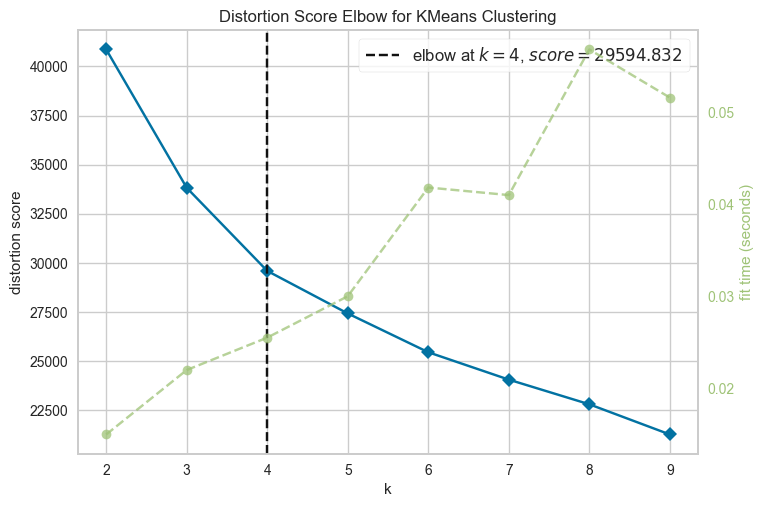


Based on the elbow method, the optimal number of clusters is: k = 4


In [130]:
# 5. Finding the Optimal Number of Clusters (k) with the Elbow Method
model = KMeans(random_state=42, n_init=10)
visualizer = KElbowVisualizer(model, k=(2, 10), locate_elbow=True)

print("Finding optimal 'k' for customer segmentation...")
visualizer.fit(X_scaled)        
visualizer.show()               

optimal_k = visualizer.elbow_value_
if optimal_k is not None:
    print(f"\nBased on the elbow method, the optimal number of clusters is: k = {optimal_k}")
else:
    print("\nCould not find a distinct elbow. You may need to manually inspect the plot.")

In [131]:
k_opt = visualizer.elbow_value_
final_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('kmeans', KMeans(n_clusters=k_opt, random_state=42, n_init=10))
])

final_pipeline.fit(X)
labels = final_pipeline.named_steps['kmeans'].labels_

# If you want the labels back on the dataframe:
df.loc[X.index, 'cluster'] = labels

In [132]:
# Apply PCA to reduce dimensions to 2
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)

In [133]:
# Create a new DataFrame for plotting
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['cluster'] = labels

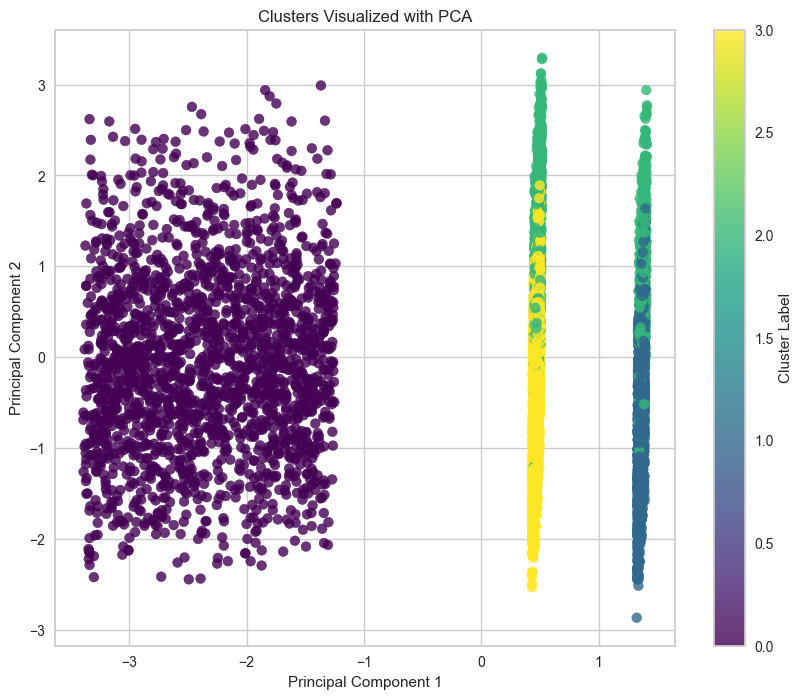

In [134]:
# Plot the clusters
plt.figure(figsize=(10, 8))
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['cluster'], cmap='viridis', s=50, alpha=0.8)
plt.title('Clusters Visualized with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.colorbar(label='Cluster Label')
plt.show()

In [135]:
df['cluster'] = df['cluster'].astype(int)
print("\nCluster assignments added to the dataframe.")


Cluster assignments added to the dataframe.


In [136]:
df.head()

,user_id,gender,age,country,subscription_type,listening_time,songs_played_per_day,skip_rate,device_type,ads_listened_per_week,offline_listening,is_churned,cluster
0,1,Female,54,CA,0,26,23,0.20,Desktop,31,0,1,0
1,2,Other,33,DE,0,141,62,0.34,Web,0,1,0,3
2,3,Male,38,AU,1,199,38,0.04,Mobile,0,1,1,2
3,4,Female,22,CA,0,36,2,0.31,Mobile,0,1,0,3
4,5,Other,29,US,0,250,57,0.36,Mobile,0,1,1,2


In [137]:

# Get the labels assigned to each data point
labels = final_pipeline.named_steps['kmeans'].labels_

# Get the cluster centroids
# We get the centroids from the KMeans step and then inverse transform them
# to get them back to the original data scale for plotting.
centroids = final_pipeline.named_steps['kmeans'].cluster_centers_
centroids_original = final_pipeline.named_steps['scaler'].inverse_transform(centroids)

In [142]:
cluster_counts = df['cluster'].value_counts().sort_index()

print("Cluster-wise count of users:")
print(cluster_counts)

Cluster-wise count of users:
cluster
0    2018
1    1585
2    1568
3    2829
Name: count, dtype: int64


In [143]:
# Group the data by cluster and calculate the mean for each feature
cluster_profiles = df.groupby('cluster')[['ads_listened_per_week', 'songs_played_per_day', 'subscription_type', 'listening_time', 'is_churned','skip_rate','offline_listening']].mean()

# The result will be a DataFrame showing the average values for each cluster
print("Cluster Profiles (Average Values per Cluster):")
print(cluster_profiles)

Cluster Profiles (Average Values per Cluster):
         ads_listened_per_week  songs_played_per_day  subscription_type  \
cluster                                                                   
0                     27.52775             49.204163            0.00000   
1                      0.00000             49.485804            1.00000   
2                      0.00000             50.976403            0.33801   
3                      0.00000             50.674443            0.00000   

         listening_time  is_churned  skip_rate  offline_listening  
cluster                                                            
0            154.997027    0.249257   0.300922                0.0  
1            156.728707    0.000000   0.294360                1.0  
2            152.707908    1.000000   0.303342                1.0  
3            152.669141    0.000000   0.301011                1.0  


In [144]:
# Group by 'subscription_type' and calculate the average for key metrics
subscription_profiles = df.groupby('subscription_type')[['songs_played_per_day', 'listening_time','ads_listened_per_week']].mean()

print("Average Metrics by Subscription Type:")
print(subscription_profiles)

Average Metrics by Subscription Type:
                   songs_played_per_day  listening_time  ads_listened_per_week
subscription_type                                                             
0                             50.264741      153.545455               9.439422
1                             49.744681      155.522931               0.000000
